# Technique Inference Engine (TIE)

This notebook allows you to train, run, and experiment with the Technique Inference Engine.

*For more information about the TIE Project visit our [Website](https://center-for-threat-informed-defense.github.io/technique-inference-engine/).*

## 1. Import Dependencies

If you haven't already, we highly recommend using [Poetry](https://python-poetry.org/) to setup the project's virtual environment and dependencies using:

`poetry install`

In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.manifold
import tensorflow as tf
import tie.recommender
from tie.constants import PredictionMethod
from tie.engine import TechniqueInferenceEngine
from tie.matrix_builder import ReportTechniqueMatrixBuilder
from tie.recommender import (
    BPRRecommender,
    FactorizationRecommender,
    ImplicitBPRRecommender,
    ImplicitWalsRecommender,
    Recommender,
    TopItemsRecommender,
    WalsRecommender,
)

tf.config.run_functions_eagerly(True)

assert tf.executing_eagerly()

importlib.reload(tie.recommender)


/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'tie.recommender' from '/Users/mjturner/code/technique-inference-engine/src/tie/recommender/__init__.py'>

## 2. Configure your Data

### Configuring your Dataset
Your dataset should be a `.json` file in the same form as `combined_dataset_full_frequency.json`. 

Once formatted properly, set `dataset_filepath` to the path of your dataset file.

### Configuring ATT&CK Version
To use a specific version of ATT&CK, download the appropriate [STIX file](https://github.com/mitre-attack/attack-stix-data/tree/master/enterprise-attack) and set `enterprise_attack_filepath` to the path of the downloaded STIX file.

### Set Validation and Test Ratios
Use `validation_ratio` to set the percentage of data used to select the best hyperparameters.

Use `test_ratio` to set the percentage of data used to evaluate the model's performance.

All remaining data will be used for training.

In [ ]:
validation_ratio = 0.1
test_ratio = 0.2

# data locations
dataset_filepath = "../data/combined_dataset_full_frequency.json"
enterprise_attack_filepath = "../data/stix/enterprise-attack.json"

# make data
data_builder = ReportTechniqueMatrixBuilder(
    combined_dataset_filepath=dataset_filepath,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
training_data, test_data, validation_data = data_builder.build_train_test_validation(test_ratio, validation_ratio)

print("Num training interactions", training_data.to_numpy().sum())
print("Num test interactions", test_data.to_numpy().sum())
print("Num validation interactions", validation_data.to_numpy().sum())

## 3. Experiment with Embedding Dimensions

The following cell defines a function that trains and selects the best hyperparameters and embedding dimension for a given `Recommender` model. 

We've found that an embedding dimension of 4 generally performs the best.

In [10]:

def test_multiple_embedding_dimensions(model_class: Recommender, method: PredictionMethod, out_file: str, **kwargs):
    """Runs model_class at multiple embedding dimensions and saves results.

    Runs each model for embedding dimensions 4, 8, 10, 16, 32, and 64.

    Args:
        model_class: A model on which to train at multiple embedding dimensions.
        out_file: filename for saving the results file.  Requires len(out_file) > 0
            and out_file is a valid csv filename.
        kwargs: Parameters mapped to values.

    Mutates:
        Saves model results, including embedding_dimension, hyperparameters,
        and precision, recall, and ndcg at 10, 20, 50, and 100 to out_file.
    """
    assert len(out_file) > 0

    results = []

    embedding_dimensions = (4,8,10,16,32,64)
    # for every embedding
    for embedding_dimension in embedding_dimensions:

        # make model
        model = model_class(
            m=training_data.m,
            n=training_data.n,
            k=embedding_dimension,
        )

        # make tie
        tie = TechniqueInferenceEngine(
            training_data=training_data,
            validation_data=validation_data,
            test_data=test_data,
            model=model,
            prediction_method=method,
            enterprise_attack_filepath=enterprise_attack_filepath,
        )

        # fit hyperparameters
        best_hyperparameters = tie.fit_with_validation(**kwargs)

        # calculate precision, recall, ndcg
        run_stats = {
            "embedding_dimension": embedding_dimension,
            **best_hyperparameters
        }
        k_values = (10, 20, 50, 100)
        for k in k_values:
            run_stats[f"precision_at_{k}"] = tie.precision(k=k)
            run_stats[f"recall_at_{k}"] = tie.recall(k=k)
            run_stats[f"ndcg_at_{k}"] = tie.normalized_discounted_cumulative_gain(k=k)

        print(run_stats)
        results.append(run_stats)


    # save as csv
    results_dataframe = pd.DataFrame(results)
    results_dataframe.to_csv(out_file)

### 3a. Experiment with Embedding Dimensions (WALS Recommender)

The following cell will train TIE using a WALS Recommender Model. In the process, it will select the best hyperparameters and embedding dimension.

In [7]:
test_multiple_embedding_dimensions(
    model_class=WalsRecommender,
    method=PredictionMethod.DOT,
    out_file="wals_model_results_training_data_correction_dot.csv",
    epochs=[25],
    c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    regularization_coefficient=[0.0, 0.00001, 0.0001, 0.001, 0.01]
)

### 3b. Experiment with Embedding Dimensions (BPR Recommender)

The following cell will train TIE using a BPR Recommender Model. In the process, it will select the best hyperparameters and embedding dimension.


In [9]:
test_multiple_embedding_dimensions(
    model_class=BPRRecommender,
    method=PredictionMethod.DOT,
    out_file="bpr_model_results.csv",
    epochs=[20],
    learning_rate=[0.00001, 0.00005, 0.0001, 0.001],
    regularization=[0., 0.0001, 0.001, 0.01],
)

## 4. Experiment with Different Models

The following cells allow you to compare the performance of different models.

In [ ]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}

### 4a. Technique Inference Engine (Top Items Recommender)

This Technique Inference Engine uses a **"Top Items" Recommender** model to recommend Techniques. 

The "Top Items" Recommender is a (naive) model that recommends Techniques in order of their frequency in the dataset.

This model acts as a baseline and allows us to compare how other models perform against simply guessing the most popular ATT&CK Techniques.

In [3]:
embedding_dimension = 10
k = 20
best_hyperparameters = {'gravity_coefficient': 0.001, 'regularization_coefficient': 0.5, 'epochs': 1000, 'learning_rate': 100.0}

model = TopItemsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.DOT,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit()
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.04852325970978819
Precision 0.02400990099009901
Recall 0.1905249816378097
Normalized Discounted Cumulative Gain 0.1841149999164702


In [6]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data  \
T1592.004     0.000000            0.0        0.0   
T1557.001     0.586885            0.0        0.0   
T1600         0.291803            0.0        0.0   
T1647         0.293443            0.0        0.0   
T1068         0.916393            0.0        0.0   
...                ...            ...        ...   
T1656         0.149180            0.0        0.0   
T1557.003     0.147541            0.0        0.0   
T1499.001     0.145902            0.0        0.0   
T1027.005     0.708197            0.0        0.0   
T1059.007     0.896721            0.0        0.0   

                                  technique_name  
T1592.004                  Client Configurations  
T1557.001   LLMNR/NBT-NS Poisoning and SMB Relay  
T1600                          Weaken Encryption  
T1647                    Plist File Modification  
T1068      Exploitation for Privilege Escalation  
...                                          ...  
T1656             

### 4b. Technique Inference Engine (Factorization Recommender)

This Technique Inference Engine uses a **Matrix Factorization** model to recommend Techniques.

Use `.fit()` if you want to explicitly set the model's hyperparameters.

Use `.fit_with_validation()` if you want TIE to choose the best hyperparameters for you.

#### Limitations
This model is not designed to handle negative examples.

In [14]:
embedding_dimension = 10
k = 20
best_hyperparameters = {'gravity_coefficient': 0.001, 'regularization_coefficient': 0.001, 'epochs': 10, 'learning_rate': 1.0}

model = FactorizationRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.DOT,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_validation(
#     learning_rate=[0.001, 0.01, 0.1, 1.0, 10., 20., 50., 100.],
#     epochs=[1000],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
#     gravity_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)


Mean Squared Error 8.200210708280245
Precision 0.0014993585631815267
Recall 0.018532725776008053
Normalized Discounted Cumulative Gain 0.00973503731752359


In [17]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

            predictions  training_data  test_data  \
T1204.002 -44127.687500            0.0        0.0   
T1592.001 -18382.687500            0.0        0.0   
T1547.012  43962.042969            0.0        0.0   
T1561.002  46403.843750            0.0        0.0   
T1110.004  67053.593750            0.0        0.0   
...                 ...            ...        ...   
T1612      34722.996094            0.0        0.0   
T1588.006 -39228.710938            0.0        0.0   
T1003     -42823.429688            0.0        0.0   
T1069.002 -36731.289062            0.0        0.0   
T1070.005  12406.809570            0.0        0.0   

                             technique_name  
T1204.002                    Malicious File  
T1592.001                          Hardware  
T1547.012                  Print Processors  
T1561.002               Disk Structure Wipe  
T1110.004               Credential Stuffing  
...                                     ...  
T1612                   Build Image on Ho

### 4c. Technique Inference Engine (BPR Recommender)

This Technique Inference Engine uses a **BPR Recommender** model to recommend Techniques.

Use `.fit()` if you want to explicitly set the model's hyperparameters.

Use `.fit_with_validation()` if you want TIE to choose the best hyperparameters for you.

In [11]:
# hyperparameters
embedding_dimension = 4
k = 20
best_hyperparameters = {'regularization_coefficient': 0.01, 'epochs': 25, 'learning_rate': 0.001}

model = BPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
# mse = tie.fit_with_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     epochs=[20],
#     regularization_coefficient=[0, 0.0001, 0.001, 0.01],
# )
mse = tie.fit(**best_hyperparameters)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=20)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.35926297
Precision 0.015426555484284798
Recall 0.18590974575666436
Normalized Discounted Cumulative Gain 0.1027035699039283


In [12]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data               technique_name
T1484.002    -0.778899            0.0        0.0    Domain Trust Modification
T1098.004    -0.598990            0.0        0.0          SSH Authorized Keys
T1021.005    -0.643423            0.0        0.0                          VNC
T1074.002    -0.689918            0.0        0.0          Remote Data Staging
T1003.007    -0.975197            0.0        0.0              Proc Filesystem
...                ...            ...        ...                          ...
T1056.003    -0.464340            0.0        0.0           Web Portal Capture
T1588.006    -0.841596            0.0        0.0              Vulnerabilities
T1552.001     0.289389            0.0        0.0         Credentials In Files
T1552.005    -0.838721            0.0        0.0  Cloud Instance Metadata API
T1568         0.160313            0.0        0.0           Dynamic Resolution

[611 rows x 4 columns]


### 4d. Technique Inference Engine (Implicit BPR Recommender)

This Technique Inference Engine also uses a **BPR Recommender** model to recommend Techniques. 

This implementation uses the [`implicit` library's](https://github.com/benfred/implicit) implementation of BPR.

Use `.fit()` if you want to explicitly set the model's hyperparameters.

Use `.fit_with_validation()` if you want TIE to choose the best hyperparameters for you.

#### Limitations

Due to limitations in the `implicit` library, this model does not implement `predict_for_new_report()`.

In [13]:
# hyperparameters
embedding_dimension = 10
k = 20
best_hyperparameters = {'regularization_coefficient': 0.0001, "epochs": 20, 'learning_rate': 0.005}

model = ImplicitBPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
# mse = tie.fit_with_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     epochs=[20],
#     regularization=[0, 0.0001, 0.001, 0.01],
# )
mse = tie.fit(**best_hyperparameters)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

100%|██████████| 20/20 [00:00<00:00, 273.67it/s, train_auc=52.35%, skipped=9.64%]


Mean Squared Error 0.7785285753506571
Precision 0.00785760102629891
Recall 0.10888739825282506
Normalized Discounted Cumulative Gain 0.048864361156135426


### 4e. Technique Inference Engine (Implicit WALS Recommender)

This Technique Inference Engine uses a **WALS Recommender** model to recommend Techniques. 

This implementation uses the [`implicit` library's](https://github.com/benfred/implicit) implementation of ALS.

Use `.fit()` if you want to explicitly set the model's hyperparameters.

Use `.fit_with_validation()` if you want TIE to choose the best hyperparameters for you.

In [14]:
# hyperparameters
embedding_dimension = 10
k = 20
best_hyperparameters = {'regularization_coefficient': 0.05, 'c': 0.5, 'epochs': 20}

model = ImplicitWalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_validation(
#     epochs=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 20/20 [00:00<00:00, 30.03it/s]


Mean Squared Error 0.5062082146675281
Precision 0.008362732520846697
Recall 0.11422344217877621
Normalized Discounted Cumulative Gain 0.05967858085464743


In [15]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data               technique_name
T1484.002     0.124266            0.0        0.0    Domain Trust Modification
T1098.004     0.444776            0.0        0.0          SSH Authorized Keys
T1021.005     0.329030            0.0        0.0                          VNC
T1074.002     0.303619            0.0        0.0          Remote Data Staging
T1003.007     0.040659            0.0        0.0              Proc Filesystem
...                ...            ...        ...                          ...
T1056.003     0.189562            0.0        0.0           Web Portal Capture
T1588.006     0.037500            0.0        0.0              Vulnerabilities
T1552.001     0.393371            0.0        0.0         Credentials In Files
T1552.005     0.327949            0.0        0.0  Cloud Instance Metadata API
T1568         0.126907            0.0        0.0           Dynamic Resolution

[611 rows x 4 columns]


### 4f. Technique Inference Engine (WALS Recommender)

This Technique Inference Engine also uses a **WALS Recommender** model to recommend Techniques.

Use `.fit()` if you want to explicitly set the model's hyperparameters.

Use `.fit_with_validation()` if you want TIE to choose the best hyperparameters for you.

In [18]:
# hyperparameters
embedding_dimension = 4
k = 20

best_hyperparameters = {'regularization_coefficient': 0.00001, 'c': 0.001, "epochs": 25}
model = WalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.DOT,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_validation(
#     epochs=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.8097925249418998
Precision 0.03033996151379089
Recall 0.4200376984456249
Normalized Discounted Cumulative Gain 0.2295893796141917


In [19]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data               technique_name
T1484.002     0.000080            0.0        0.0    Domain Trust Modification
T1098.004     0.006258            0.0        0.0          SSH Authorized Keys
T1021.005     0.012727            0.0        0.0                          VNC
T1074.002     0.011960            0.0        0.0          Remote Data Staging
T1003.007     0.000122            0.0        0.0              Proc Filesystem
...                ...            ...        ...                          ...
T1056.003     0.004489            0.0        0.0           Web Portal Capture
T1588.006     0.002095            0.0        0.0              Vulnerabilities
T1552.001     0.049055            0.0        0.0         Credentials In Files
T1552.005     0.002569            0.0        0.0  Cloud Instance Metadata API
T1568         0.010783            0.0        0.0           Dynamic Resolution

[611 rows x 4 columns]


## 5. Plot a Model's Performance

This cell uses the currently trained model (from section 4) to chart the accuracy of the model over the number of techniques returned by the model.

Ideally, this chart should depict a rapid increase in accuracy as more techniques are included before plateauing.

recalls [0.030450054688467964, 0.15645718642963535, 0.2705757415206124, 0.4200376984456249, 0.5150937977229236, 0.5792033446063182, 0.6291256155184046, 0.6674650570756567, 0.7043606414509712, 0.7320416385374856, 0.7560748088674433, 0.7777067489017366, 0.7967956532746462, 0.8135556661276224, 0.8268209729200038, 0.8384301585152386, 0.8507378241924031, 0.8607554934628231, 0.867841889646102, 0.8772007108770467, 0.8818684148112542]


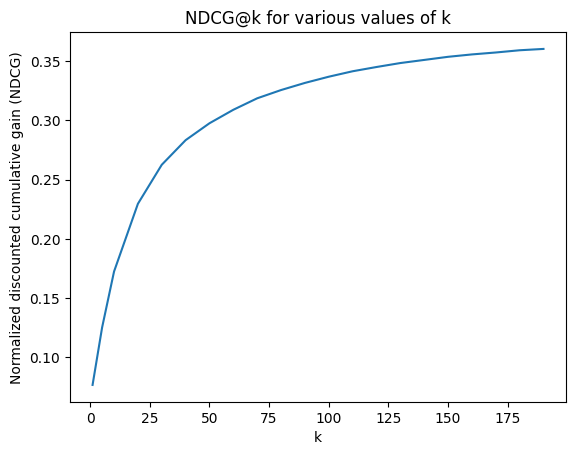

In [20]:
k_values = [1, 5] + list(range(10, 200, 10))
recalls = []
ndcgs = []
for k in k_values:
    precision = tie.precision(k=k)

    recall = tie.recall(k=k)
    recalls.append(recall)

    ndcg = tie.normalized_discounted_cumulative_gain(k=k)
    ndcgs.append(ndcg)

print("recalls", recalls)

plt.xlabel("k")
plt.ylabel("Normalized discounted cumulative gain (NDCG)")
plt.title("NDCG@k for various values of k")
plt.plot(k_values, ndcgs)

In [22]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)

print(new_report_predictions.sort_values(by="predictions", ascending=False).head(10))

           predictions  training_data  test_data  \
T1105         0.381902            1.0        0.0   
T1027         0.332577            1.0        0.0   
T1071.001     0.326495            1.0        0.0   
T1059.003     0.320938            1.0        0.0   
T1566.001     0.293094            0.0        0.0   
T1204.002     0.278039            0.0        0.0   
T1082         0.270586            1.0        0.0   
T1059.001     0.252522            0.0        0.0   
T1547.001     0.251486            0.0        0.0   
T1140         0.251313            0.0        0.0   

                                    technique_name  
T1105                        Ingress Tool Transfer  
T1027              Obfuscated Files or Information  
T1071.001                            Web Protocols  
T1059.003                    Windows Command Shell  
T1566.001                 Spearphishing Attachment  
T1204.002                           Malicious File  
T1082                 System Information Discovery  
T10

## 6. Visualize Embeddings

Because the model's reports exist in an embedding dimension greater than 4, it can be difficult to visualize how the reports are clustered. This cell uses the currently trained model (from section 4) to plot a 2-dimensional representation of the model's embeddings using t-SNE. In the chart below, reports that are far apart in the 4-dimensional space are similarly distant in the 2-dimensional space.

If you wish to visualize how techniques are clustered (instead of reports), switch:

```python
U = tie.get_U()
x_1, x_2 = make_tsne_embeddings(U)
```

to:
```python
V = tie.get_V()
x_1, x_2 = make_tsne_embeddings(V)
```

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 6236 samples in 0.002s...
[t-SNE] Computed neighbors for 6236 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6236
[t-SNE] Computed conditional probabilities for sample 2000 / 6236
[t-SNE] Computed conditional probabilities for sample 3000 / 6236
[t-SNE] Computed conditional probabilities for sample 4000 / 6236
[t-SNE] Computed conditional probabilities for sample 5000 / 6236
[t-SNE] Computed conditional probabilities for sample 6000 / 6236
[t-SNE] Computed conditional probabilities for sample 6236 / 6236
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.067368
[t-SNE] KL divergence after 10000 iterations: 0.773501


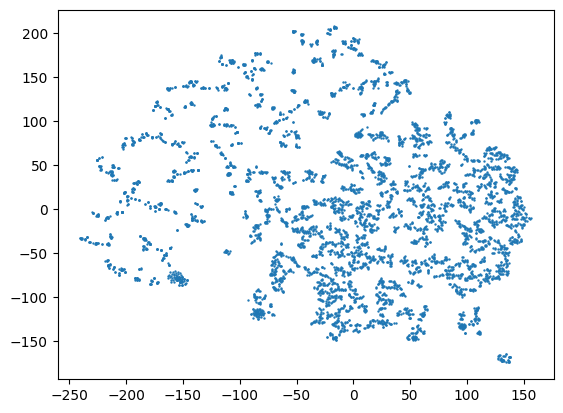

In [23]:
def make_tsne_embeddings(embeddings: np.ndarray) -> tuple[np.array, np.array]:
    """Create 2D representation of embeddings using t-SNE.

    Args:
        embeddings: an mxk array of m embeddings in k-dimensional space.

    Returns:
        A tuple of the form (x_1, x_2) where x_1 and x_2 are length m
        such that (x_1[i], x_2[i]) is the 2-dimensional point cotnaining the 2-dimensional
        repsresentation for embeddings[i, :].
    """
    tsne = sklearn.manifold.TSNE(
        n_components=2,
        perplexity=15,
        learning_rate="auto",
        # metric='cosine',
        # early_exaggeration=10.0,
        init='pca',
        verbose=True,
        n_iter=10000,
    )

    V_proj = tsne.fit_transform(embeddings)
    x = V_proj[:, 0]
    y = V_proj[:, 1]

    return x, y

U = tie.get_U()
x_1, x_2 = make_tsne_embeddings(U)

plt.scatter(x_1, x_2, s=0.5)
plt.show()

*Copyright © 2024 MITRE Engenuity. Approved for public release. Document number(s) CT0124.*